In [1]:
#imports 
!pip install seaborn 
import numpy as np
from scipy.integrate import odeint, ode, quad #ignore this?
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import astropy.units as u
import seaborn as sns
sns.set_style("whitegrid")

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.2
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
%matplotlib inline

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#defining constants
e=-1.6*(10**-19)*u.coulomb #electronic charge
a=5.3*(10**-11)*u.m #bohr radius
ke=9.0*(10**9)*u.kg*(u.m**3)*(u.coulomb**(-2))*(u.s**-2) #constant in the coulomb force
me=9.1*(10**-31)*u.kg #mass of the electron
ioncharge=100*e #charge of the ion
c=3.0*10**8*u.m/u.s #the speed of light
epsilon_0= 8.8*10**-12*(u.coulomb**2)*(u.s**-2)*(u.kg**-1)*(u.m**-3) #permittivity of free space

In [3]:
 def force(r):
    #the Coulomb acceleration
    return ke*ioncharge*e/(r**2)/me

def euler_solver(x0, y0, v0x, v0y, tf,N):
    """
    Using euler's method to solve the differential equation f=ma
    
    x0=initial x-position
    y0= initial y-position
    idem for v
    tf=final time
    N=number of steps
    """
    vx=v0x
    vy=v0y
    
    x=x0
    y=y0
    
    
    pos=[]
    vels=[]
    ts=[]
    accs=[]
    
    step=tf/N
    for t in np.linspace(0, tf, N)*u.s:
        r=np.sqrt(x**2+y **2)
        theta=np.arctan(y/x)
        acc=force(r)
        
        #calculate the x and y components of the acceleration, velocity and position
        accx=acc*np.cos(theta)
        accy=acc*np.sin(theta)
        
        vx = vx+step*accx
        vy = vy+step*accy
        
        x = step*vx+x
        y = step*vy+y
        #print (h)
        pos.append([x.value, y.value])
        vels.append([vx.value, vy.value])
        ts.append(t.value)
        accs.append([accx.value, accy.value])
        
    pos=np.array(pos)*u.m
    vels=np.array(vels)*u.m/u.s
    ts=np.array(ts)*u.s
    accs=np.array(accs)*u.m/(u.s**2)
    
    #print (ts)
    return {'pos':pos, 'v':vels, 't':ts, 'ac':accs}

### Plots of Velocity, Position and Acceleration

In the following plot, I simulated 20 electrons with different initial positions around (0, 0) moving at 200 m/s in the x-direction
and starting at y0=1 cm.I use only 20 steps

> #### Explanation of the first figure: 
>> The arrows are the magnitude and direction of the velocities
>> The colormap shows the mean amount of acceleration throughout the trajectory
>> It's a way of displaying the strength of the field




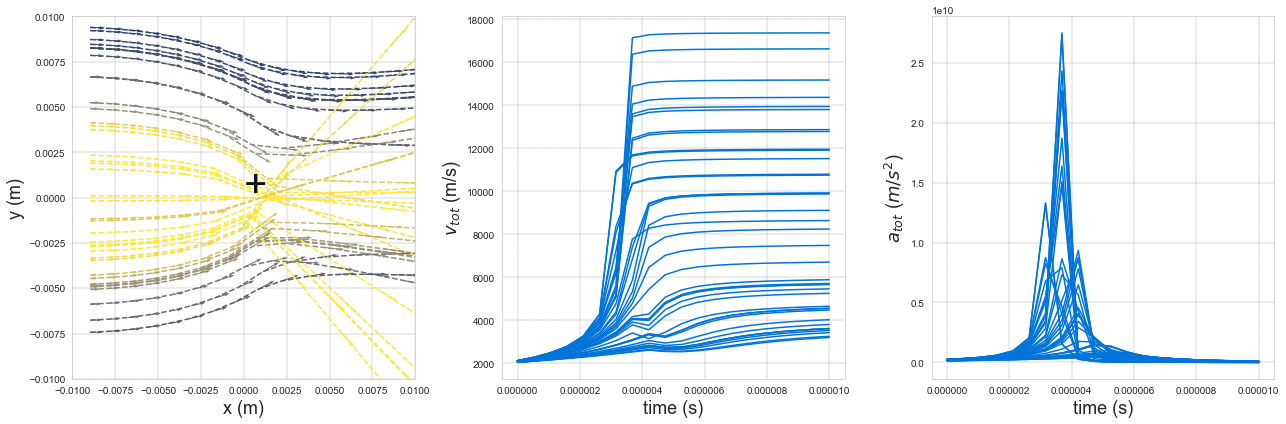

In [4]:
#normalize the colormap for pollting 
norm = mpl.colors.Normalize(vmin=10**8, vmax=10**9)
cmap = cm.cividis
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, (ax0, ax1, ax2)=plt.subplots(ncols=3, figsize=(18, 6))


#choose 20 electrons of both pposive and negative initial conditions moving in the y-direction at 2000m/s
#integrate this over a periof of 10^-5 seconds 

pos_ys=10**-2*np.random.random(20)
neg_ys=-10**-2*np.random.random(20)

all_paths=[]
for y in np.concatenate([pos_ys,neg_ys])*u.m :
    
    vals=euler_solver( -10**-2*u.m, y,  2000.0*u.m/u.s, 0.0*u.m/u.s, 10**-5*u.s,20)
    total_acc=np.nanmean(np.sqrt(vals['ac'][:,0]**2 +vals['ac'][:,1]**2))
    #print  (total_acc)
    ax0.quiver(vals['pos'][:,0], vals['pos'][:,1],  vals['v'][:,0], vals['v'][:,1], alpha=1, \
              color=m.to_rgba(total_acc), width=0.003)
    ax0.plot(vals['pos'][:,0], vals['pos'][:,1], alpha=1, linestyle='--', color=m.to_rgba(total_acc))
    all_paths.append(vals)
    
    #I'm plotting the total velocity vs time
    ax1.plot(vals['t'], np.sqrt(vals['v'][:,0]**2+vals['v'][:,1]**2), c='#0074D9')
    ax2.plot(vals['t'], np.sqrt(vals['ac'][:,0]**2+vals['ac'][:,1]**2), c='#0074D9')


ax0.set_xlabel('x (m)', fontsize=18)
ax0.set_ylabel('y (m)', fontsize=18)

ax1.set_xlabel('time (s)', fontsize=18)
ax1.set_ylabel(r'$v_{tot}$ (m/s)', fontsize=18)

ax2.set_xlabel('time (s)', fontsize=18)
ax2.set_ylabel(r'$a_{tot}$ ($m/s^2$)', fontsize=18)

ax0.set_xlim([-10**-2, 10**-2])
ax0.set_ylim([-10**-2, 10**-2])
ax0.text(0.0, 0.0, '+', fontsize=40, color='#111111') #this seems looks off in the actula image
#ax.scatter([0], [0], 'x')

plt.tight_layout()

In [5]:
#calculate the power radiated by this distribution of electrons
def impact_parameter(pos):
    """
    x, y are arrays of postions over time,
    find the closest to zero
    """
    x=pos[:,0]
    y=pos[:,1]
    rs=np.sqrt(x**2+y**2)
    minidx =rs.argmin()
    return rs[minidx]

#power radiated
def power_radiated(vel):
    #power radiated
    v, b=vel
    tau=b/v
    omega=2*np.pi/tau
    z=ioncharge/e
    dEdw=8*(z**2)*(e**6)/(3*np.pi*(c**3)*(me**2)*(v**2)*(b**2))*10**76 #a correction because units are off ? 
    return omega, dEdw

In [6]:
paths_df=pd.DataFrame(all_paths)

In [7]:
paths_df['b']=paths_df.pos.apply(impact_parameter)
paths_df['v_tot']=paths_df.v.apply(lambda x: np.sqrt(x[:,0]**2+x[:,1]**2))

In [8]:
paths_df['mean_acc']=paths_df['ac'].apply(lambda x : np.nanmean(np.sqrt(x[:,0]**2 +x[:,1]**2)))

### Power Radiated

I'm plotting dW/domega as a function of omega

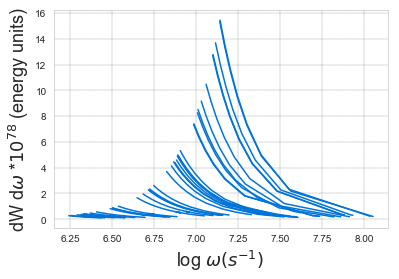

In [9]:
wmax=[]
bs=[]
for idx in paths_df.index: 
    b0=paths_df['b'][idx]
    v0=paths_df['v_tot'][idx]
    omega, power=power_radiated([v0, b0])
    #print (omega)
    bs.append(b0.value)
    wmax.append(np.nanmax(omega).value)
    plt.plot(np.log10(omega.value), power,c='#0074D9')
    plt.xlabel(r'log $\omega $$(s^{-1})$ ', fontsize=18)
    plt.ylabel(r'dW d$\omega$ *$10^{78}$ (energy units)', fontsize=18)
    

Text(0, 0.5, '$\\omega_{max}$')

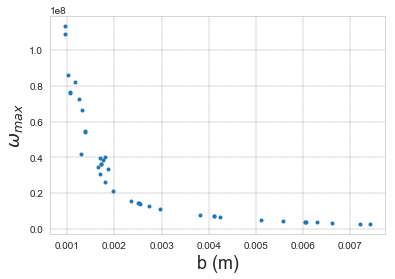

In [10]:
plt.plot(bs, wmax, '.')
plt.xlabel(r'b (m)', fontsize=18)
plt.ylabel(r'$\omega_{max}$', fontsize=18)